In [2]:
%matplotlib inline
import sys 
sys.path.append('..')
import matplotlib
import mglearn
import os

from preamble import *
plt.rcParams['image.cmap'] = "gray"

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

from matplotlib.pyplot import rc
rc('font',family='New Gulim') #plot 한글폰트 적용

cancer = load_breast_cancer()

In [3]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# 0~255 사이의 흑백 이미지의 픽셀 값을 0~1 사이로 스케일 조정합니다.
# (옮긴이) MinMaxScaler를 적용하는 것과 거의 동일합니다.
X_people = X_people / 255.

from sklearn.neighbors import KNeighborsClassifier
# 데이터를 훈련 세트와 테스트 세트로 나눕니다
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)

### 3.4.2 NMF (음수 미포함 행렬 분해)

- NMF
    - It is a group of algorithms where a matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements.
    - This non-negativity makes the resulting matrices easier to inspect.
    - Also, in applications such as processing of audio spectrograms or muscular activity, non-negativity is inherent to the data being considered. Since the problem is not exactly solvable in general, it is commonly approximated numerically.
    - 0 또는 양수로만 구성된 W와 H만을 생성
    - W와 H의 각 원소가 음수가 아니므로 원 데이터의 특성에 음수가 없어야 함.
    - https://en.wikipedia.org/wiki/Non-negative_matrix_factorization
- NMF 활용 데이터
    - 음성/악기 오디오 데이터
    - 여러 악기 또는 음성이 섞여 있는 데이터에서 각 원본 성분들을 구분할 수 있음
- PCA vs. NMF
    - PCA
        - 음수 성분이나 계수가 만드는 효과의 이해가 어려움.
        - 실제로 부호에는 아무런 규칙이 없음
    - NMF
        - 상대적으로 PCA보다 해석하기 쉬움.
        - 모든 주성분 사이에 원본 데이터의 특질을 더 많이 포함하는 중요도 차이가 없음 --> 즉 모든 주성분은 동등하게 중요
        - W와 H의 무작위 초기화 --> 난수 생성 초기값에 따라 결과가 달라짐

#### 인공 데이터에 NMF 적용하기

- 원본 데이터 확인
    - 원본 데이터의 각 성분이 양수인지 확인하는 작업 필요
    - 각 데이터가 원점 (0,0)에서 상대적으로 어디에 놓여 있는가가 중요.
    - 즉, 원점 (0,0)에서 데이터가 향하는 방향을 추출한 것으로서 음수미포함 성분 이해 가능

- NMF 알고리즘
    - V: 원본 데이터 행렬
    - W: 새롭게 변환된 행렬
    - H: 주성분 행렬
    - V와 W*H가 유사하도록 조절
        - n_components는 주어짐
            - V가 (x,y) 크기의 행렬이면
            - n_components = n
            - W는 (x*n), H는 (n*y) 크기
            - V = W*H => (x,y) = (x*n)*(n*Y)
            - n_components가 클 수록 원본에 가까움
    - the approximation of V by V≃WH is achieved by minimizing the error function
$$ minW,H||V−WH||F, subject to W≥0,H≥0 $$
.
    - 아래 논문을 활용하여 위와 같은 최적화 문제 해결
        - Daniel D. Lee & H. Sebastian Seung (2001). Algorithms for Non-negative Matrix Factorization (PDF). Advances in Neural Information Processing Systems 13: Proceedings of the 2000 Conference. MIT Press. pp. 556–562.

In [9]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

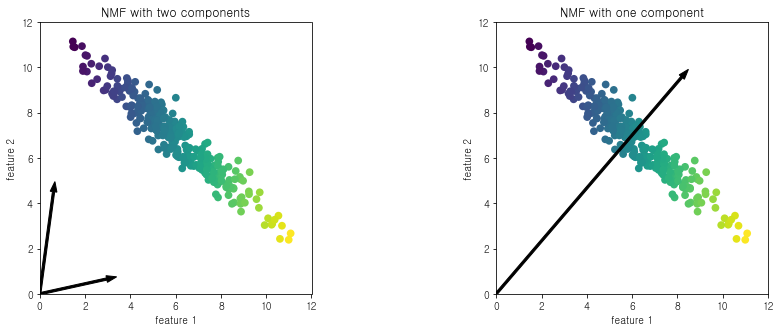

In [10]:
mglearn.plots.plot_nmf_illustration()

- 첫번째 그래프
    - 주성분 2개
        - 데이터의 각 특성마다 끝에 위치한 포인트를 가리키는 방향으로 주성분 구성
        - 총 100개의 원본 데이터: Shape (100, 2)에 대한 행렬 분해 결과
            - V (100 x 2) = W (100 x 2) x H (2 x 2)
        - 새롭게 변환된 특성 데이터: W (100 x 2)
- 두번째 그래프
    - 주성분 1개
        - 데이터를 가장 잘 표현하는 각 특성마다 평균값으로 향하는 주성분을 구성
        - 총 100개의 원본 데이터: Shape (100, 2)에 대한 행렬 분해 결과
            - V (100 x 2) = W (100 x 1) x H (1 x 2)
        - 새롭게 변환된 특성 데이터: W (100 x 1)

### 얼굴 이미지에 NMF 적용하기

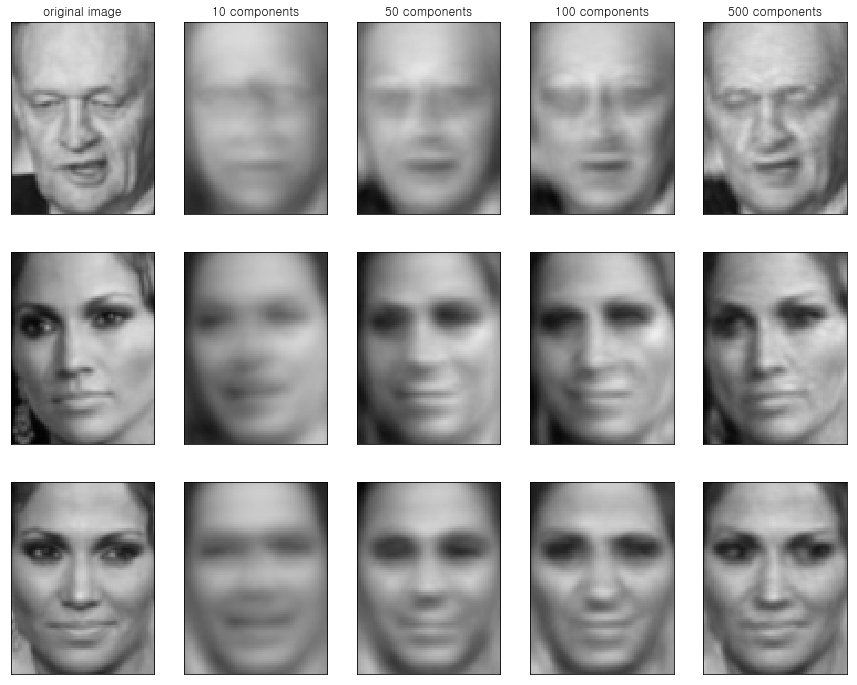

In [14]:
mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)

- 훈련 데이터에 대한 비음수 분해: V = WH
    - 원본 훈련 데이터 1,482개 V: Shape - (1486, 5655)
    - 새롭게 변환된 행렬 W: Shape - (1486, 15)
    - 주성분 데이터 H: Shape - (15, 5655) 
- 테스트 데이터에 대한 비음수 분해: V=WH
    - 원본 테스트 데이터 494개 V: Shape - (494, 5655)
    - 새롭게 변환된 행렬 W: Shape - (494, 15)
    - 주성분 데이터 H: Shape - (15, 5655) 
- [주의] 훈련 데이터에 대한 Fit 이후 테스트 데이터에 대한 Transform
    - NMF는 Fit에 대한 의미없음
        - https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/decomposition/nmf.py#L1246
    - Transform 이 호출될 때 주어진 데이터에 대한 NMF 분해 시작하여 Transform의 반환값으로 W를 반환함.
    - 즉, 비지도학습에 대해 훈련 데이터와 테스트 데이터를 구분하여 작업하는 것은 의미없음 (아래와 같은 코딩은 하면 안됨)

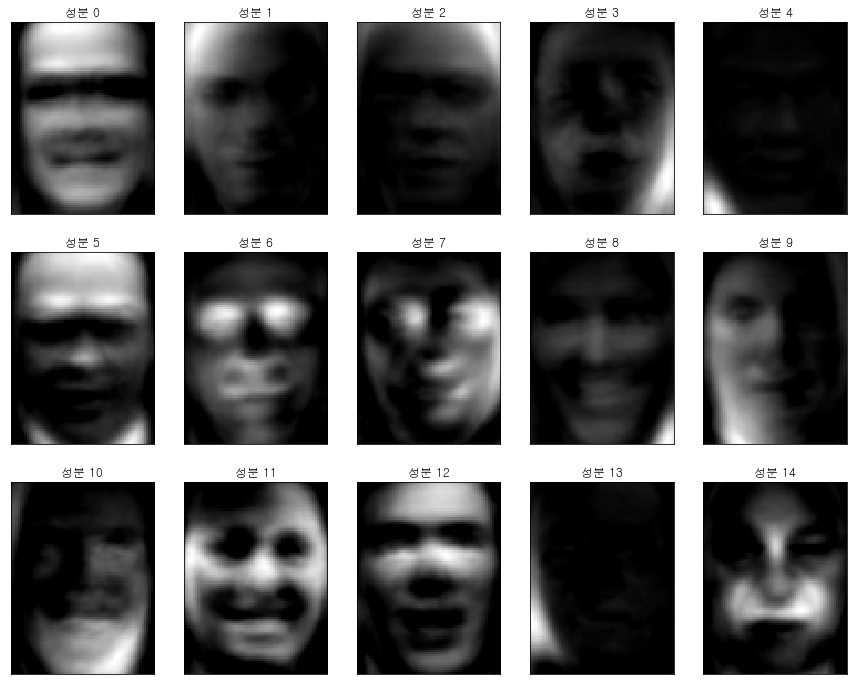

In [13]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
#nMF에 대한 W의 결과, transform에서 학습
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("성분 {}".format(i))

- 그림 : 찾아낸 주성분의 특성 결과

- 주성분 0~14 중 하나를 선택 --> compn 변수에 할당
- NMF 알고리즘에 의하여 변환된 훈련 데이터: W (1486, 15)
- 변환된 훈련 데이터의 각 특성중 compn 위치 값이 가장 큰 10개 선택하여 해당 10개에 대한 원본 데이터를 이미지 형태로 출력

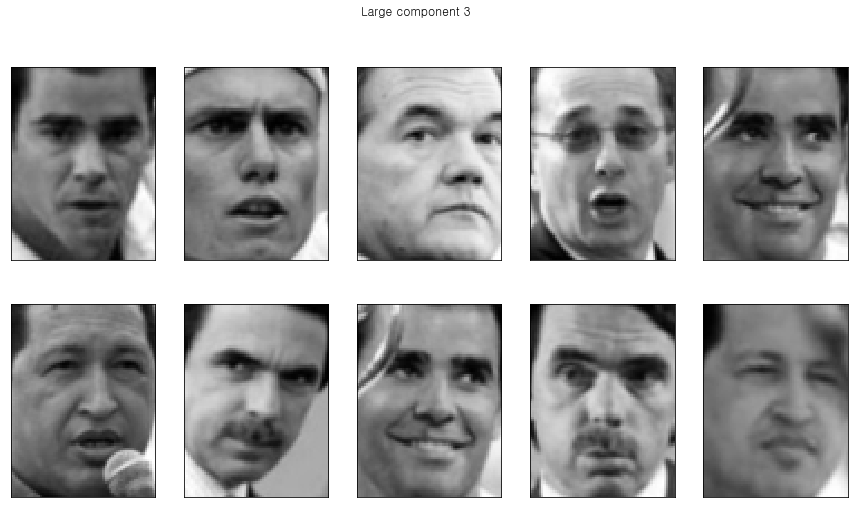

In [18]:
compn = 3
# 4번째 성분으로 정렬하여 처음 10개 이미지를 출력합니다
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle("Large component 3")
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

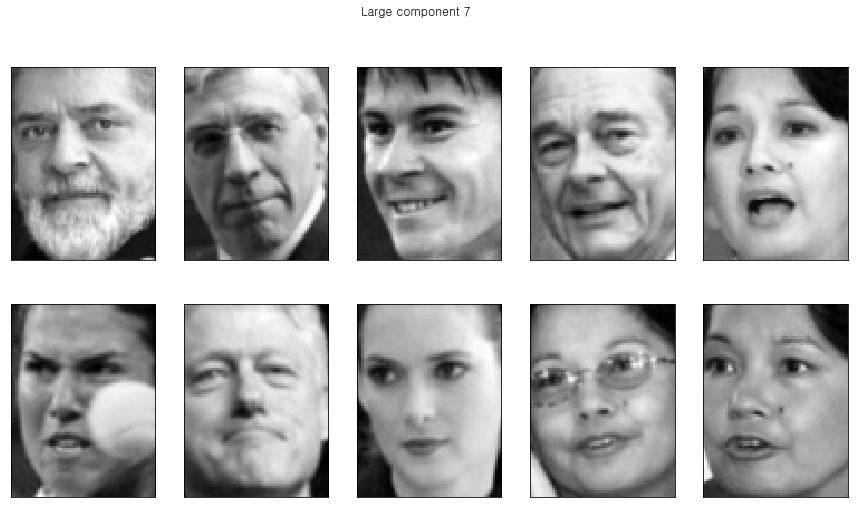

In [19]:
compn = 7
# 8번째 성분으로 정렬하여 처음 10개 이미지를 출력합니다
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle("Large component 7")
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

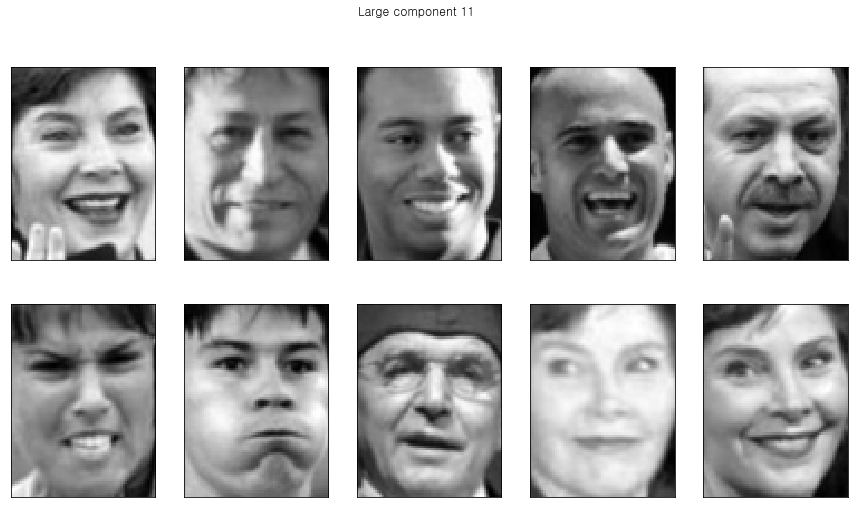

In [20]:
compn = 11
# sort by 3rd component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle("Large component 11")
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

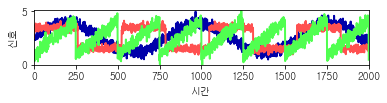

In [22]:
S = mglearn.datasets.make_signals()
plt.figure(figsize=(6, 1))
plt.plot(S, '-')
plt.xlabel("시간")
plt.ylabel("신호")
plt.margins(0)

측정 데이터 형태: (2000, 100)


Text(0,0.5,'신호')

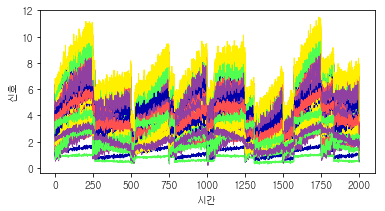

In [24]:
# 원본 데이터를 사용해 100개의 측정 데이터를 만듭니다
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("측정 데이터 형태: {}".format(X.shape))

plt.figure(figsize=(6, 3))
plt.plot(X, '-', linewidth=1.0)
plt.xlabel("시간")
plt.ylabel("신호")

In [11]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("복원한 신호 데이터 형태: {}".format(S_.shape))

복원한 신호 데이터 형태: (2000, 3)


In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
H = pca.fit_transform(X)

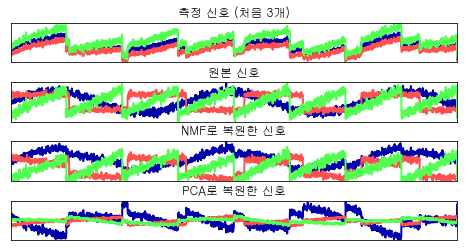

In [14]:
models = [X, S, S_, H]
names = ['측정 신호 (처음 3개)',
         '원본 신호',
         'NMF로 복원한 신호', 
         'PCA로 복원한 신호']

fig, axes = plt.subplots(4, figsize=(8, 4), gridspec_kw={'hspace': .5},
                         subplot_kw={'xticks': (), 'yticks': ()})

for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')
    ax.margins(0)

### t-SNE를 이용한 매니폴드 학습

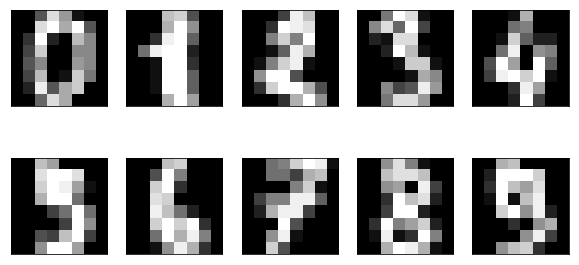

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                         subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)